<a href="https://colab.research.google.com/github/sergiosb99/SSJ_SupervisedLearning/blob/Novelty/Dengue_Upgrade_Clustering_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **0. Introduction**


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# **1. Libraries**

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [1]:
# Loading the data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import io
from google.colab import files

# Graphics display
import seaborn as sns
import matplotlib.pyplot as plt

# Estimator and model selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Classification
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

# Clustering
from sklearn.cluster import KMeans
from sklearn import metrics

# Others
import numpy as np    
from sklearn.metrics import mean_absolute_error

#  **2. Loading the data**

The first step is to upload all the CSV files that have been provided to us and that thanks to them we will obtain the data with which we are going to work. To do this, we will use the tools that Google Colab offers us when uploading files.

# Preprocessing the data

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, etc.

We first load the datasets, and merge them in one, named train.

In [2]:
train_feat = pd.read_csv('dengue_features_train.csv')

In [3]:
train_labels = pd.read_csv('dengue_labels_train.csv')

In [4]:
train = pd.merge(train_feat,train_labels,on=['city','year','weekofyear'])

We upload the test dataset in order to know how good our model is.

In [5]:
test = pd.read_csv('dengue_features_test.csv')

We fill the Nan values:

In [6]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [7]:
train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


We are going to select this features for our training:

In [8]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']


Now we are going to divide the dataset in two, one for each city. We are going to train two models depending on the city.


First we obtain all the cases from San Juan:

In [9]:
df_sj = train[train['city']=='sj']
df_sj

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,-0.052750,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3



Now from Iquitos:

In [10]:
df_iq = train[train['city']=='iq']
df_iq

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


We remove first the years that in previous notebook were deleted.

In [11]:
#San Juan
df_sj.drop(df_sj[df_sj['year']==2000].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2002].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2004].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2006].index,inplace=True)
df_sj.drop(df_sj[df_sj['year']==2008].index,inplace=True)

#Iquitos
df_iq.drop(df_iq[df_iq['year']==2000].index,inplace=True)
df_iq.drop(df_iq[df_iq['year']==2001].index,inplace=True)
df_iq.drop(df_iq[df_iq['year']==2003].index,inplace=True)

Now we are going to obtain some clusters in the San Juan dataset in order to classify and train our models:

In [12]:
# parameters
init = 'random' 

# to run 10 times with different random centroids 
iterations = 10

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance 
tol = 1e-04 

 # random seed
random_state = 0

In [13]:
distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(df_sj[selected_features])
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(df_sj[selected_features], labels))

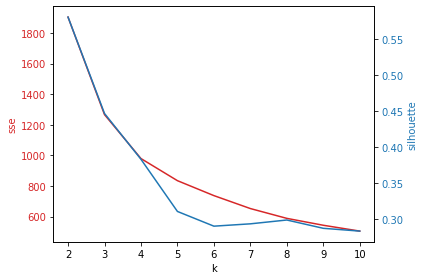

In [14]:
x = [i for i in range(2,11)]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('sse', color=color)
ax1.plot(x, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(x, silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

The best representation is 8, however, the best result in the competition is with 3.

In [16]:
print ("Number of clusters", 3)
km = KMeans(3, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(df_sj[selected_features])

Number of clusters 3


In [17]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_sj[selected_features], y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.447
Distortion: 1266.91


In [18]:
km.labels_

array([2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,

We label every sample in the dataset.

In [19]:
df_sj['group'] = km.labels_

In [20]:
df_sj.groupby("group")['total_cases'].mean()

group
0    36.839378
1    55.018237
2    24.190476
Name: total_cases, dtype: float64

#**3. Detaching the dataset**

To train the models that we make, it is necessary to separate our training dataset into two parts, one precisely to train the model, and another to check if our models are good.

In this case, we are going to use five differents models, four for San Juan (for each cluster) and one for Iquitos.

In [21]:
X_train_sj_group0, X_test_sj_group0, y_train_sj_group0, y_test_sj_group0 = train_test_split(df_sj[df_sj['group']==0][selected_features], df_sj[df_sj['group']==0]['total_cases'], test_size=0.2, random_state=1)

In [22]:
X_train_sj_group1, X_test_sj_group1, y_train_sj_group1, y_test_sj_group1 = train_test_split(df_sj[df_sj['group']==1][selected_features], df_sj[df_sj['group']==1]['total_cases'], test_size=0.3, random_state=1)

In [23]:
X_train_sj_group2, X_test_sj_group2, y_train_sj_group2, y_test_sj_group2 = train_test_split(df_sj[df_sj['group']==2][selected_features], df_sj[df_sj['group']==2]['total_cases'], test_size=0.2, random_state=1)

Iquitos:

In [24]:
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(df_iq[selected_features], df_iq['total_cases'], test_size=0.2, random_state=1)

#**4. Execution of the algorithm**

For our models, we are going to use Random Forest. This algorithm is a set of Decision Trees, where each tree at the end of its execution will offer a result, at the end of all trees, the result will be the average of all the results.

In [25]:
def RandomForest(X_train, X_test,y_train,y_test,n_e,m_depth,title):
    #1.1 Model Parametrization 
    regressor = RandomForestRegressor(n_estimators= n_e, max_depth = m_depth, criterion='mae', random_state=0)
    #1.2 Model construction
    regressor.fit(X_train, y_train)
    # Test
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    print ("Error Measure ",  mae, "\n")
    xx = np.stack(i for i in range(len(y_test)))
    plt.scatter(xx, y_test, c='r', label='data')
    plt.plot(xx, y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(title)

    plt.show()
    return regressor


We run the algorithm with the data from San Juan and the first cluster:

Error Measure  32.511153846153846 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


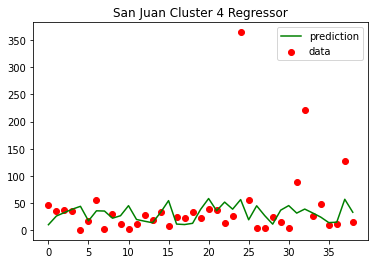

In [26]:
model_sj_group0 = RandomForest(X_train_sj_group0, X_test_sj_group0,y_train_sj_group0,y_test_sj_group0,1000,4,"San Juan Cluster 4 Regressor")

The second cluster:

Error Measure  42.21360606060606 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


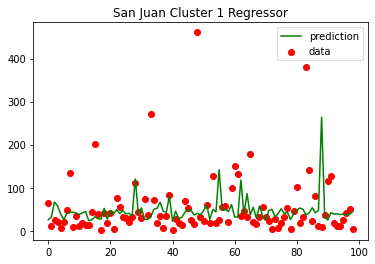

In [27]:
model_sj_group1 = RandomForest(X_train_sj_group1, X_test_sj_group1,y_train_sj_group1,y_test_sj_group1,500,5,"San Juan Cluster 1 Regressor")

The third cluster:

Error Measure  14.87578947368421 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


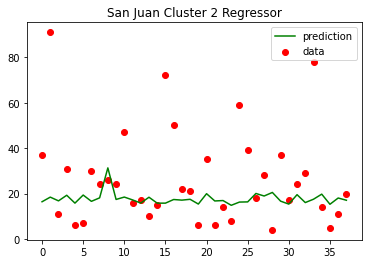

In [28]:
model_sj_group2 = RandomForest(X_train_sj_group2, X_test_sj_group2,y_train_sj_group2,y_test_sj_group2,1000,4,"San Juan Cluster 2 Regressor")

We run the algorithm with the data from Iquitos:

Error Measure  6.628397435897436 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


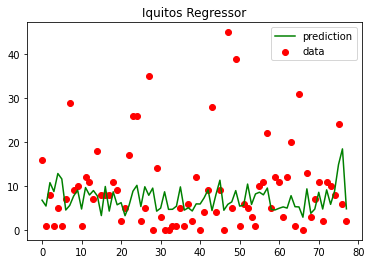

In [29]:
model_iq = RandomForest(X_train_iq,X_test_iq,y_train_iq,y_test_iq,500,4,"Iquitos Regressor")

# **5. Model to classify the test dataset**

To make the predictions, we need to know in which group correspond each sample. So, we need to make a model which classify each cluster.

We first divide our dataframe from San Juan and we use as target the column group.

In [30]:
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(df_sj[selected_features], df_sj['group'], test_size=0.3, random_state=1)

We now train our model:

In [31]:
clf = RandomForestClassifier(n_estimators = 500) # Number of trees.
clf.fit(X_train_sj, y_train_sj)
y_pred = clf.predict(X = X_test_sj)
acc = accuracy_score(y_test_sj, y_pred)
print ('Accuracy of the model: ', acc)

Accuracy of the model:  0.9813084112149533


In [32]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    
    if not title:
        if normalize: title = 'Normalized confusion matrix'
        else: title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = 'Predicted label')
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center", color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

We visualize the classification:

Confusion matrix, without normalization
[[ 48   2   1]
 [  0 106   0]
 [  1   0  56]]


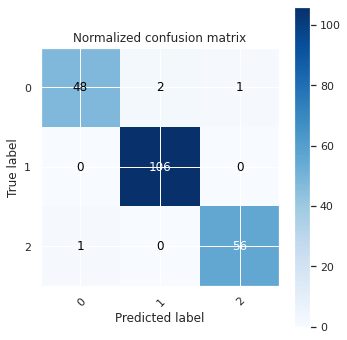

In [33]:
sns.set(rc={'figure.figsize':(5,5)})
plot_confusion_matrix(y_test_sj, y_pred, classes = unique_labels(y_test_sj, y_pred), normalize = False, title = 'Normalized confusion matrix')

It is a good result, so we are going to use it for our data.

#**Submission result**

Now, we are going to test our model with the data provided to us in the dengue_features_test.csv file to predict dengue cases for the weeks proposed in said file.

As we have three models, we have to predict five times, so the test dataset must be splitted in five, depending on the city and each group (only in San Juan).


Cases from San Juan:

In [34]:
sj_test = test[test['city']=='sj']
sj_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.00150,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,-0.00150,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,sj,2013,13,2013-03-26,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
256,sj,2013,14,2013-04-02,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
257,sj,2013,15,2013-04-09,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4
258,sj,2013,16,2013-04-16,0.08275,0.031200,0.135014,0.074857,0.00,298.912857,299.064286,294.678571,300.9,297.3,1.40,77.674286,0.00,15.965714,3.042857,27.728571,6.942857,31.7,23.9,22.9


We predict in which group corresponds each sample:

In [35]:
sj_test['group'] = clf.predict(sj_test[selected_features])

We divide the dataset:

In [44]:
sj_test_group0 = sj_test[sj_test['group']==0]
sj_test_group1 = sj_test[sj_test['group']==1]
sj_test_group2 = sj_test[sj_test['group']==2]

Cases from Iquitos:

In [45]:
iq_test = test[test['city']=='iq']
iq_test

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700,8.480,32.2,21.8,34.1



We predict with the cases from San Juan's clusters:

In [46]:
final_model_prediction_sj_group0 = model_sj_group0.predict(sj_test[sj_test['group']==0][selected_features])

In [47]:
final_model_prediction_sj_group1 = model_sj_group1.predict(sj_test[sj_test['group']==1][selected_features])

In [48]:
final_model_prediction_sj_group2 = model_sj_group2.predict(sj_test[sj_test['group']==2][selected_features])

And now with the cases from Iquitos:

In [49]:
final_model_prediction_iq = model_iq.predict(iq_test[selected_features])

We put together both results in order to obtain the final result:

In [51]:
sj_test_group0['total_cases'] = final_model_prediction_sj_group0
sj_test_group1['total_cases'] = final_model_prediction_sj_group1
sj_test_group2['total_cases'] = final_model_prediction_sj_group2
iq_test['total_cases'] = final_model_prediction_iq

In [54]:
frames = [sj_test_group0,sj_test_group1,sj_test_group2,iq_test]
final_prediction = pd.concat(frames)
final_prediction.sort_index()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,group,total_cases
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0.0,21.8615
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0.0,20.5875
2,sj,2008,20,2008-05-13,-0.001500,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0.0,12.1745
3,sj,2008,21,2008-05-20,-0.001500,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1.0,86.9000
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0.0,8.6130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,NaN,4.5630
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,NaN,4.3840
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,NaN,4.9260
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,NaN,4.0280


Finally we try to visualize how our prediction has turned out with reality.

In [55]:
# round the result and cast to int
y = np.rint(final_prediction['total_cases']) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 22,  21,  12,   9,  73,  40,  17,  48,  32,  28,  24,  22,  22,
        17,  60,  25,  24,  43,  29,  41,  23,  23,  38,  35,  32,  22,
        18,  26,  11,  31,  68,  31,  33,  29,  27,  23,  31,  32,  59,
        39, 102,  42,  43,  48,  22,  34,  21,  28,  25,  27,  18,  34,
        15,  26,  11,  31,  21,  27,  27,   8,  24,  12,   9,  24,  87,
       113,  39,  28,  42,  26,  35,  49,  32,  48,  43,  39,  52, 102,
        71,  49,  46,  68,  32,  28,  54,  28,  53,  24,  26,  32,  49,
        38,  41,  37,  40,  39,  42,  32,  40,  43,  44,  47,  36,  46,
        44,  41,  59,  42,  48,  47,  48,  53,  35,  32,  48,  49,  33,
        49,  79,  58,  43,  40,  60, 117, 119,  60,  76,  50, 121,  62,
       121,  84, 118, 103,  44,  40,  49,  98,  35,  28,  22,  53,  37,
        72, 109, 126,  82,  60,  77,  41,  96,  43, 113,  79, 107,  73,
        42,  53,  41,  73,  76,  42,  34,  44,  37, 115,  35,  30,  31,
        41,  47,  32,  38,  32,  39,  76,  32,  51,  67,  44,  3

We build the output file


In [56]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = res.astype(np.int64)
submission.to_csv("result.csv")

**And the result is:**

28.9062
Woo! I scored 28.9062 on 'DengAI: Predicting Disease Spread'!